In [32]:
from datetime import datetime
import itertools
import json
import math
import os

import geopandas
import importlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import psycopg2
import scipy
from scipy.spatial import KDTree
import seaborn as sns
from sklearn import metrics
import torch
from torch.utils.data import DataLoader

from database import data_utils, data_loader, shape_utils, database_utils
from models import basic_ff
import run_models

importlib.reload(data_utils)
importlib.reload(basic_ff)
importlib.reload(data_loader)
importlib.reload(shape_utils)
importlib.reload(database_utils)

from dotenv import load_dotenv
load_dotenv()

%matplotlib inline

RUN_FOLDER = "../results/throwaway/"

In [33]:
# Load run data
train_traces = data_utils.load_pkl(RUN_FOLDER + "kcm/" + "train_traces.pkl")
test_traces = data_utils.load_pkl(RUN_FOLDER + "kcm/" + "test_traces.pkl")
with open(RUN_FOLDER + "kcm/deeptte_formatted/" + "config.json") as f:
    config = json.load(f)
gtfs_data = data_utils.merge_gtfs_files("." + config['gtfs_folder'])
tte_train_chunks, tte_test = data_utils.load_train_test_data(RUN_FOLDER + "kcm/deeptte_formatted/", 5)

In [34]:
# Work with a single trip
shingle_data = test_traces[test_traces['shingle_id']==5885]
shingle_data.head()

,trip_id,file,locationtime,lat,lon,vehicle_id,shingle_id,speed_m_s,dist_calc_m,time_calc_s,...,trip_start_timeID_s,scheduled_time_s,vehicle_id_recode,dist,time,dist_gap,time_gap,lats,lngs,vehicleID
108505,46645090,2021_03_01.pkl,1614611833,47.714809,-122.185722,8183.0,5885,6.886392,275.455687,40.0,...,26233,-44,138,0.000000,0,0.000000,0,47.714809,-122.185722,138
108506,46645090,2021_03_01.pkl,1614611863,47.714798,-122.186462,8183.0,5885,1.851495,55.544853,30.0,...,26233,-44,138,0.055545,30,0.055545,30,47.714798,-122.186462,138
108507,46645090,2021_03_01.pkl,1614611900,47.714798,-122.186462,8183.0,5885,0.000000,0.000000,37.0,...,26233,-44,138,0.055545,67,0.055545,67,47.714798,-122.186462,138
108508,46645090,2021_03_01.pkl,1614611935,47.712135,-122.186523,8183.0,5885,8.459499,296.082456,35.0,...,26233,44,138,0.351627,102,0.351627,102,47.712135,-122.186523,138
108509,46645090,2021_03_01.pkl,1614611957,47.711189,-122.191544,8183.0,5885,17.778273,391.121995,22.0,...,26233,142,138,0.742749,124,0.742749,124,47.711189,-122.191544,138


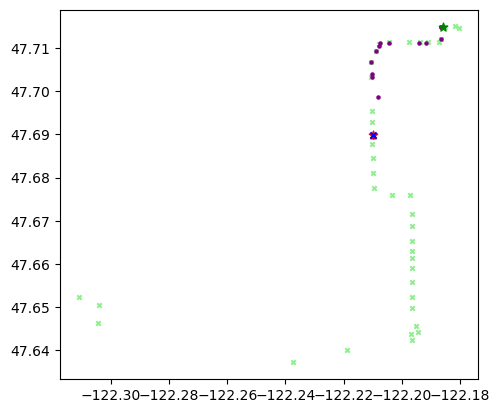

In [35]:
# Plot overview of the shingle
plot_data = shingle_data
fig, axes = plt.subplots(1,1)
shape_utils.plot_gtfs_trip(axes, plot_data['trip_id'].iloc[0], gtfs_data)
shape_utils.plot_gtfsrt_trip(axes, plot_data)

In [36]:
# Plot closest stop updates across shingle
plot_data = shingle_data
next_stops = plot_data[['stop_lon','stop_lat','timeID_s']]
next_stops.columns = ["lon","lat","timeID_s"]
next_stops['Type'] = "Nearest Scheduled Stop"
next_points = shingle_data[['lon','lat','timeID_s']]
next_points['Type'] = "Current Position"
next_points = shape_utils.interpolate_trajectories(next_points, 'Type')
next_stops = shape_utils.fill_trajectories(next_stops, np.min(next_points['timeID_s']), np.max(next_points['timeID_s']), 'Type')
plot_data = pd.concat([next_points, next_stops], axis=0)

fig = px.scatter(
    plot_data,
    title=f"Nearest Stop to Target",
    x="lon",
    y="lat",
    range_x=[np.min(plot_data['lon'])-.01, np.max(plot_data['lon'])+.01],
    range_y=[np.min(plot_data['lat'])-.01, np.max(plot_data['lat'])+.01],
    animation_frame="timeID_s",
    animation_group="Type",
    color="Type"
)
fig.update_traces(marker={'size': 15})
fig.update_layout(
  template='plotly_dark',
  margin=dict(r=60, t=25, b=40, l=60)
)
fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 30
fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 5
fig.write_html("../plots/nearest_stop.html")
fig.show()

In [37]:
shingle_id = 5885
dist = .002
t_buffer = 60
shingle_data, adjacent_data = shape_utils.get_adjacent_points(test_traces, shingle_id, t_buffer, dist)

# Join and interpolate each trajectory
plot_shingle_data = shape_utils.interpolate_trajectories(shingle_data, 'shingle_id')
plot_shingle_data['Type'] = 'Trajectory'
plot_adjacent_data = shape_utils.interpolate_trajectories(adjacent_data, 'shingle_id')
plot_adjacent_data['Type'] = 'Adjacent Trip'
# For some reason Plotly needs data to be sorted by the animation frame
plot_data = pd.concat([plot_shingle_data, plot_adjacent_data], axis=0).sort_values(['timeID_s','shingle_id'])

# Plot adjacent shingles
fig = px.scatter(
    plot_data,
    title=f"Active Shingles Within {dist*111*1000}m and {t_buffer}s of Target",
    x="lon",
    y="lat",
    range_x=[np.min(plot_data['lon'])-.01, np.max(plot_data['lon'])+.01],
    range_y=[np.min(plot_data['lat'])-.01, np.max(plot_data['lat'])+.01],
    animation_frame="timeID_s",
    animation_group="shingle_id",
    # color="Type", # For some reason this breaks the animation order
    text="Type"
)
fig.update_layout(
  template='plotly_dark',
  margin=dict(r=60, t=25, b=40, l=60)
)
fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 30
fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 5
fig.write_html("../plots/adjacent_trips.html")
fig.show()

In [38]:
# Show overview of trace and adjacent on a map
px.set_mapbox_access_token(os.getenv('MAPBOX_TOKEN'))
fig = px.scatter_mapbox(
    plot_data,
    lon="lon",
    lat="lat",
    color="Type"
)
fig.update_layout(
  margin=dict(r=60, t=25, b=40, l=60)
)
fig.write_html("../plots/adjacent_trip_traces.html")
fig.show()

In [39]:
all_x_pos = []
all_x_neg = []
all_y_pos = []
all_y_neg = []
for i in [2,4,8,16,32,64,128,256,512]:
    # Decompose speeds into X and Y components
    point_obs = train_traces[['lon','lat','speed_m_s','bearing']].values
    x_speed_m_s, y_speed_m_s = shape_utils.decompose_velocity(point_obs[:,2], point_obs[:,3])

    # Decompose X and Y speeds into EW/NS components
    x_speed_m_s = np.column_stack([point_obs[:,:2], x_speed_m_s])
    x_pos_speed_m_s = x_speed_m_s[x_speed_m_s[:,2]>=0.0]
    x_neg_speed_m_s = x_speed_m_s[x_speed_m_s[:,2]<=0.0]
    y_speed_m_s = np.column_stack([point_obs[:,:2], y_speed_m_s])
    y_pos_speed_m_s = y_speed_m_s[y_speed_m_s[:,2]>=0.0]
    y_neg_speed_m_s = y_speed_m_s[y_speed_m_s[:,2]<=0.0]

    # Get regularly spaced 2d bins at given resolution across bbox for all collected points
    xbins, ybins = shape_utils.get_2d_bins(point_obs[:,0], point_obs[:,1], resolution=i)

    # Aggregate and rasterize speed data into the 2d bins
    x_pos_speed_rast, x_count_rast = shape_utils.rasterize_values(x_pos_speed_m_s[:,0], x_pos_speed_m_s[:,1], x_pos_speed_m_s[:,2], xbins, ybins)
    x_neg_speed_rast, x_count_rast = shape_utils.rasterize_values(x_neg_speed_m_s[:,0], x_neg_speed_m_s[:,1], x_neg_speed_m_s[:,2], xbins, ybins)
    y_pos_speed_rast, y_count_rast = shape_utils.rasterize_values(y_pos_speed_m_s[:,0], y_pos_speed_m_s[:,1], y_pos_speed_m_s[:,2], xbins, ybins)
    y_neg_speed_rast, y_count_rast = shape_utils.rasterize_values(y_neg_speed_m_s[:,0], y_neg_speed_m_s[:,1], y_neg_speed_m_s[:,2], xbins, ybins)
    all_x_pos.append(x_pos_speed_rast)
    all_x_neg.append(x_neg_speed_rast)
    all_y_pos.append(y_pos_speed_rast)
    all_y_neg.append(y_neg_speed_rast)
    
# Get the factors that each heatmap must be scaled by to match highest resolution
scalar_dims = [2**i for i in range(len(all_x_pos))]
scalar_dims.reverse()

# Scale each heatmap to the highest resolution
all_x_pos = np.array(shape_utils.upscale(all_x_pos, scalar_dims))
all_x_neg = np.array(shape_utils.upscale(all_x_neg, scalar_dims))
all_y_pos = np.array(shape_utils.upscale(all_y_pos, scalar_dims))
all_y_neg = np.array(shape_utils.upscale(all_y_neg, scalar_dims))

# Create single array with all, plotly requires col_wrap so add them to same dimension
res = np.concatenate([all_x_pos, all_x_neg, all_y_pos, all_y_neg])
print(res.shape)

(36, 512, 512)


In [40]:
# Plot all directions/speeds/resolutions
fig = px.imshow(
  res,
  facet_col=0,
  facet_col_wrap=9
)
fig.write_html("../plots/faceted_speeds.html")
# fig.show() # This figure really slows down the notebook

In [41]:
# Plot closeup of one result for X/Y
plot_data = np.array([all_x_pos[7], all_y_pos[7]])
fig = px.imshow(
  plot_data,
  facet_col=0
)
fig.write_html("../plots/faceted_speeds_closeup.html")
# fig.show() # This figure really slows down the notebook

In [42]:
# Trying to find relationships between nearby trips and ongoing trip
dist = .002
t_buffer = 60 * 1
shingle_ids = pd.unique(test_traces['shingle_id'])[:1000]
adj_metric = np.empty(len(shingle_ids))
target_metric = np.empty(len(shingle_ids))

# Get values for adjacent points to a subset of shingles
for i, shingle_id in enumerate(shingle_ids):
    shingle_data, adjacent_data = shape_utils.get_adjacent_points(test_traces, shingle_id, t_buffer, dist)
    # Test different metrics for evaluating adjacent traces on target trace
    target_metric[i] = np.mean(shingle_data.speed_m_s)
    adj_metric[i] = np.mean(adjacent_data.speed_m_s)

# Fill points with no adjacent with global average
adj_metric = np.nan_to_num(adj_metric, nan=np.mean(adj_metric[~np.isnan(adj_metric)]))

In [43]:
x = adj_metric
y = target_metric

# Fit polynomial to the data
z = np.polyfit(x=x, y=y, deg=2)
x_val = np.arange(np.min(x),np.max(x),.1)
p = np.poly1d(z)
y_val = p(x_val)

# Get metrics
# R2: variance explained by model / total variance
SSR = np.sum((y - p(x))**2)
SST = np.sum((y - np.mean(y))**2)
R2 = 1 - (SSR/SST)
print(f"R2: {R2}")

plot_data = pd.concat([
    pd.DataFrame({
        "x": x,
        "y": y,
        "Type": "data"
    }),
    pd.DataFrame({
        "x": x_val,
        "y": y_val,
        "Type": "pred"
    })
])
fig = px.scatter(
    plot_data,
    y="y",
    color="Type",
    x="x",
    title=f"Mean Adjacent Speed D=2 Polynomial R-Squared: {np.round(R2,3)}",
    labels={
        "x": "Mean Speed of Adjacent Trips (m/s)",
        "y": "Mean Speed of Target Trip (m/s)",
    }
)
fig.write_image("../plots/speed_reg.png")
fig.show()

R2: 0.14235432910211676


In [44]:
zero_idx_adj = adj_metric!=0.0
zero_idx_target = target_metric!=0.0
x = np.log(adj_metric[zero_idx_adj & zero_idx_target])
y = np.log(target_metric[zero_idx_adj & zero_idx_target])

# Fit polynomial to the data
z = np.polyfit(x=x, y=y, deg=2)
x_val = np.arange(np.min(x),np.max(x),.1)
p = np.poly1d(z)
y_val = p(x_val)

# Get metrics
# R2: variance explained by model / total variance
SSR = np.sum((y - p(x))**2)
SST = np.sum((y - np.mean(y))**2)
R2 = 1 - (SSR/SST)
print(f"R2: {R2}")

plot_data = pd.concat([
    pd.DataFrame({
        "x": x,
        "y": y,
        "Type": "data"
    }),
    pd.DataFrame({
        "x": x_val,
        "y": y_val,
        "Type": "pred"
    })
])
fig = px.scatter(
    plot_data,
    y="y",
    color="Type",
    x="x",
    title=f"Log Mean Adjacent Speed D=2 Polynomial R-Squared: {np.round(R2,3)}",
    labels={
        "x": "Mean Speed of Adjacent Trips Log(m/s)",
        "y": "Mean Speed of Target Trip Log(m/s)",
    }
)
fig.write_image("../plots/log_speed_reg.png")
fig.show()

R2: 0.12222368031014952
